https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/220-yolov5-accuracy-check-and-quantization

# Quantize the Ultralytics YOLOv5 model and check accuracy using the OpenVINO POT API

This tutorial demonstrates step-by-step how to perform model quantization using the OpenVINO [Post-Training Optimization Tool (POT)](https://docs.openvino.ai/latest/pot_introduction.html), compare model accuracy between the FP32 precision and quantized INT8 precision models and run a demo of model inference based on sample code from [Ultralytics Yolov5](https://github.com/ultralytics/yolov5) with the OpenVINO backend.

First, we will export the YOLOv5m model to OpenVINO IR by following the [export instructions](https://github.com/ultralytics/yolov5/issues/251) in the [Ultralytics YOLOv5 repo](https://github.com/ultralytics/yolov5). Then, we use the OpenVINO [Post-Training Optimization Tool (POT)](https://docs.openvino.ai/latest/pot_introduction.html) API to quantize the model based on the Non-Max Suppression (NMS) processing provided by Ultralytics.

OpenVINO POT provides two usages:
1. Use the API to override the model DataLoader class with custom image/annotation loading and preprocessing and identify your own class which is inherited from Metric for inference result postprocessing and accuracy calculation.
2. Use POT command line tool with the adapters provided by [Accuracy Checker](https://github.com/openvinotoolkit/open_model_zoo/blob/master/tools/accuracy_checker/README.md), pre/postprocessing and metric by configuration file. This is recommended when using [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo) models with the `omz_quantizer` tool.

The data pre/post-processing functions provided by Ultralytics are different from the Accuracy Checker provided configuration for YOLOv3. Therefore, we will need to use the POT API (approach #1) with a custom DataLoader and Metric. This enables us to include pre- and post-processing from Ultralytics in the quantization pipeline.


## Preparation

### Download the YOLOv5 model

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from addict import Dict
from IPython.display import Markdown, display

In [2]:
# if not Path("./yolov5/").exists():
#     command_download = (
#         f'{"git clone https://github.com/ultralytics/yolov5.git -b v7.0"}'
#     )
#     command_download = " ".join(command_download.split())
#     print("Download Ultralytics Yolov5 project source:")
#     display(Markdown(f"`{command_download}`"))
#     download_res = %sx $command_download
# else:
#     print("Ultralytics Yolov5 repo already exists.")

### Conversion of the YOLOv5 model to OpenVINO
There are three variables provided for easy run through all the notebook cells.
* `IMAGE_SIZE` - the image size for model input.
* `MODEL_NAME` - the model you want to use. It can be either yolov5s, yolov5m or yolov5l and so on.
* `MODEL_DIR` - the directory you want to output the model.
* `MODEL_PATH` - to the path of the `MODEL_DIR` in the YOLOv5 repository.

YoloV5 `export.py` scripts support multiple model formats for conversion. ONNX is also represented among supported formats. We need to specify `--include ONNX` parameter for exporting. As the result, directory with the `{MODEL_DIR}` name will be created with the following content:
* `{MODEL_NAME}.pt` - the downloaded pre-trained weight.
* `{MODEL_NAME}.onnx` - the Open Neural Network Exchange (ONNX) is an open format, built to represent machine learning models.

In [5]:
IMAGE_SIZE = 640
MODEL_NAME = "yolov5s"
MODEL_PATH = "weights"

In [6]:
print("Convert PyTorch model to ONNX Model:")
command_export = f"python export.py --weights {MODEL_PATH}/{MODEL_NAME}.pt --imgsz {IMAGE_SIZE} --batch-size 1 --include ONNX --simplify"
display(Markdown(f"`{command_export}`"))
! $command_export

Convert PyTorch model to ONNX Model:


`python export.py --weights weights/yolov5s.pt --imgsz 640 --batch-size 1 --include ONNX --simplify`

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



export: data=D:\code\yolov5\data\coco128.yaml, weights=['weights/yolov5s.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['ONNX']
YOLOv5  v7.0-128-gb96f35c Python-3.10.9 torch-2.0.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients

PyTorch: starting from weights\yolov5s.pt with output shape (1, 25200, 85) (14.1 MB)

ONNX: starting export with onnx 1.13.1...
ONNX: simplifying with onnx-simplifier 0.4.17...
ONNX: export success  1.6s, saved as weights\yolov5s.onnx (28.0 MB)

Export complete (2.2s)
Results saved to D:\code\yolov5\weights
Detect:          python detect.py --weights weights\yolov5s.onnx 
Validate:        python val.py --weights weights\yolov5s.onnx 
PyTorch Hub:     model = torch.hub.load('ultralyti

Convert the ONNX model to OpenVINO Intermediate Representation (IR) model generated by Model Optimizer. As the result, directory with the `{MODEL_DIR}` name will be created with the following content:
* `{MODEL_NAME}_fp32.xml`, `{MODEL_NAME}_fp32.bin` - OpenVINO Intermediate Representation (IR) model format with FP32 precision generated by Model Optimizer.
* `{MODEL_NAME}_fp16.xml`, `{MODEL_NAME}_fp16.bin` - OpenVINO Intermediate Representation (IR) model format with FP32 precision generated by Model Optimizer.

In [7]:
from openvino.tools import mo
from openvino.runtime import serialize

In [8]:
onnx_path = f"{MODEL_PATH}/{MODEL_NAME}.onnx"

# fp32 IR model
fp32_path = f"{MODEL_PATH}/{MODEL_NAME}_openvino_model_FP32/{MODEL_NAME}"
output_path = fp32_path + ".xml"

print(f"Export ONNX to OpenVINO FP32 IR to: {output_path}")
model = mo.convert_model(onnx_path)
serialize(model, output_path)

# fp16 IR model
fp16_path = f"{MODEL_PATH}/{MODEL_NAME}_openvino_model_FP16/{MODEL_NAME}"
output_path = fp16_path + ".xml"

print(f"Export ONNX to OpenVINO FP16 IR to: {output_path}")
model = mo.convert_model(onnx_path, compress_to_fp16=True)
serialize(model, output_path)

Export ONNX to OpenVINO FP32 IR to: weights/yolov5s_openvino_model_FP32/yolov5s.xml
Export ONNX to OpenVINO FP16 IR to: weights/yolov5s_openvino_model_FP16/yolov5s.xml


### Imports

In [9]:
# sys.path.append("./yolov5")

from utils.dataloaders import create_dataloader
from utils.general import (
    check_dataset,
    non_max_suppression,
    scale_boxes,
    xywh2xyxy,
    check_yaml,
)
from utils.metrics import ap_per_class
from val import process_batch

from openvino.tools.pot.api import Metric, DataLoader
from openvino.tools.pot.engines.ie_engine import IEEngine
from openvino.tools.pot.graph import load_model, save_model
from openvino.tools.pot.graph.model_utils import compress_model_weights
from openvino.tools.pot.pipeline.initializer import create_pipeline
from openvino.tools.pot.utils.logger import init_logger, get_logger

d:\miniconda3\envs\pytorch\lib\site-packages\openvino\offline_transformations\__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


## Model Quantization with POT
### Create YOLOv5 DataLoader class

Create a class for loading the YOLOv5 dataset and annotation which inherits from POT API class DataLoader. The Ultralytics YOLOv5 training process requires image data normalization from [0,225] 8-bit integer range to [0.0,1.0] 32-bit floating point range.

In [10]:
class YOLOv5DataLoader(DataLoader):
    """Inherit from DataLoader function and implement for YOLOv5."""

    def __init__(self, config):
        if not isinstance(config, Dict):
            config = Dict(config)
        super().__init__(config)

        self._data_source = config.data_source
        self._imgsz = config.imgsz
        self._batch_size = 1
        self._stride = 32
        self._single_cls = config.single_cls
        self._pad = 0.5
        self._rect = False
        self._workers = 1
        self._data_loader = self._init_dataloader()
        self._data_iter = iter(self._data_loader)

    def __len__(self):
        return len(self._data_loader.dataset)

    def _init_dataloader(self):
        dataloader = create_dataloader(
            self._data_source["val"],
            imgsz=self._imgsz,
            batch_size=self._batch_size,
            stride=self._stride,
            single_cls=self._single_cls,
            pad=self._pad,
            rect=self._rect,
            workers=self._workers,
        )[0]
        return dataloader

    def __getitem__(self, item):
        try:
            batch_data = next(self._data_iter)
        except StopIteration:
            self._data_iter = iter(self._data_loader)
            batch_data = next(self._data_iter)

        im, target, path, shape = batch_data

        im = im.float()
        im /= 255
        nb, _, height, width = im.shape
        img = im.cpu().detach().numpy()
        target = target.cpu().detach().numpy()

        annotation = dict()
        annotation["image_path"] = path
        annotation["target"] = target
        annotation["batch_size"] = nb
        annotation["shape"] = shape
        annotation["width"] = width
        annotation["height"] = height
        annotation["img"] = img

        return (item, annotation), img

### Create YOLOv5 Metric Class

Create a class to measure the model performance by Mean Average Precision (mAP) with the COCO dataset predicted result and annotation value, after applying Ultralytics NMS routine (`yolov5.utils.general.non_max_suppression`). Here, we use both AP\@0.5 and AP\@0.5:0.95 as the measurement standard. This class should be inherited from the POT API Metric class.

The `COCOMetric.update()` function contains post-processing with Non-Max Suppression to sort boxes by score and select the box with the highest score.

In [11]:
class COCOMetric(Metric):
    """Inherit from DataLoader function and implement for YOLOv5."""

    def __init__(self, config):
        super().__init__()
        self._metric_dict = {"AP@0.5": [], "AP@0.5:0.95": []}
        self._names = (*self._metric_dict,)
        self._stats = []
        self._last_stats = []
        self._conf_thres = config.conf_thres
        self._iou_thres = config.iou_thres
        self._single_cls = config.single_cls
        self._nc = config.nc
        self._class_names = {idx: name for idx, name in enumerate(config.names)}
        self._device = config.device

    @property
    def value(self):
        """Returns metric value for the last model output.
        Both use AP@0.5 and AP@0.5:0.95
        """
        mp, mr, map50, map = self._process_stats(self._last_stats)

        return {self._names[0]: [map50], self._names[1]: [map]}

    @property
    def avg_value(self):
        """Returns metric value for all model outputs.
        Both use AP@0.5 and AP@0.5:0.95
        """
        mp, mr, map50, map = self._process_stats(self._stats)

        return {self._names[0]: map50, self._names[1]: map}

    def _process_stats(self, stats):
        mp, mr, map50, map = 0.0, 0.0, 0.0, 0.0
        stats = [np.concatenate(x, 0) for x in zip(*stats)]
        if len(stats) and stats[0].any():
            tp, fp, p, r, f1, ap, ap_class = ap_per_class(
                *stats, plot=False, save_dir=None, names=self._class_names
            )
            ap50, ap = ap[:, 0], ap.mean(1)
            mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
            np.bincount(stats[3].astype(np.int64), minlength=self._nc)
        else:
            torch.zeros(1)

        return mp, mr, map50, map

    def update(self, output, target):
        """Calculates and updates metric value
        Contains postprocessing part from Ultralytics YOLOv5 project
        :param output: model output
        :param target: annotations
        """

        annotation = target[0]["target"]
        width = target[0]["width"]
        height = target[0]["height"]
        shapes = target[0]["shape"]
        paths = target[0]["image_path"]
        im = target[0]["img"]

        iouv = torch.linspace(0.5, 0.95, 10).to(
            self._device
        )  # iou vector for mAP@0.5:0.95
        niou = iouv.numel()
        seen = 0
        stats = []
        # NMS
        annotation = torch.Tensor(annotation)
        annotation[:, 2:] *= torch.Tensor([width, height, width, height]).to(
            self._device
        )  # to pixels
        lb = []
        out = output[0]
        out = torch.Tensor(out).to(self._device)
        out = non_max_suppression(
            out,
            self._conf_thres,
            self._iou_thres,
            labels=lb,
            multi_label=True,
            agnostic=self._single_cls,
        )
        # Metrics
        for si, pred in enumerate(out):
            labels = annotation[annotation[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            _, shape = Path(paths[si]), shapes[si][0]
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append(
                        (
                            torch.zeros(0, niou, dtype=torch.bool),
                            torch.Tensor(),
                            torch.Tensor(),
                            tcls,
                        )
                    )
                continue

            # Predictions
            if self._single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            scale_boxes(
                im[si].shape[1:], predn[:, :4], shape, shapes[si][1]
            )  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_boxes(
                    im[si].shape[1:], tbox, shape, shapes[si][1]
                )  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
            else:
                correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
            self._stats.append(
                (correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls)
            )
        self._last_stats = stats

    def reset(self):
        """Resets metric"""
        self._metric_dict = {"AP@0.5": [], "AP@0.5:0.95": []}
        self._last_stats = []
        self._stats = []

    def get_attributes(self):
        """
        Returns a dictionary of metric attributes {metric_name: {attribute_name: value}}.
        Required attributes: 'direction': 'higher-better' or 'higher-worse'
                                                 'type': metric type
        """
        return {
            self._names[0]: {"direction": "higher-better", "type": "AP@0.5"},
            self._names[1]: {"direction": "higher-better", "type": "AP@0.5:0.95"},
        }

### Set POT Configuration

Create a function to set the configuration of the model, engine, dataset, metric and algorithms, which are used by the POT quantization pipeline API.

Here, we use "DefaultQuantization" method for best performance of the quantization step. Alternatively, the "AccuracyAwareQuantization" method can be used to keep accuracy loss below a predefined threshold, at the cost of performance during the quantization process (it takes longer to quantize the model). This is useful when DefaultQuantization results in more accuracy loss than desired.

In [12]:
DATA_YAML  = "./data/coco128.yaml"

In [13]:
def get_config():
    """Set the configuration of the model, engine,
    dataset, metric and quantization algorithm.
    """
    config = dict()
    data_yaml = check_yaml(DATA_YAML)
    data = check_dataset(data_yaml)

    model_fp32_config = Dict(
        {
            "model_name": f"{MODEL_NAME}_fp32",
            "model": fp32_path + ".xml",
            "weights": fp32_path + ".bin",
        }
    )

    model_fp16_config = Dict(
        {
            "model_name": f"{MODEL_NAME}_fp16",
            "model": fp16_path + ".xml",
            "weights": fp16_path + ".bin",
        }
    )

    model_int8_config = Dict(
        {
            "model_name": f"{MODEL_NAME}_int8",
            "save_path": f"{MODEL_PATH}/{MODEL_NAME}_openvino_model_INT8/",
        }
    )

    engine_config = Dict(
        {"device": "CPU", "stat_requests_number": 8, "eval_requests_number": 8}
    )

    dataset_config = Dict(
        {
            "data_source": data,
            "imgsz": IMAGE_SIZE,
            "single_cls": False,
        }
    )

    metric_config = Dict(
        {
            "conf_thres": 0.001,
            "iou_thres": 0.65,
            "single_cls": False,
            "nc": 1,  # if opt.single_cls else int(data['nc']),
            "names": data["names"],
            "device": "cpu",
        }
    )

    algorithms = [
        {
            "name": "DefaultQuantization",  # or AccuracyAwareQuantization
            "params": {
                "target_device": "CPU",
                "preset": "mixed",
                "stat_subset_size": 300,
            },
        }
    ]

    config["model_fp32"] = model_fp32_config
    config["model_fp16"] = model_fp16_config
    config["model_int8"] = model_int8_config
    config["engine"] = engine_config
    config["dataset"] = dataset_config
    config["metric"] = metric_config
    config["algorithms"] = algorithms

    return config

### Run Quantization Pipeline and Accuracy Verification

The following 9 steps show how to quantize the model using the POT API. The optimized model and collected min-max values will be saved.

It will take few minutes for generating FP32-INT8 model.
> **NOTE**: *Before running next cell, check whether the quantized model is successfully saved and you get the metric results of INT8 model*

In [14]:
""" Download dataset and set config
"""
print("Run the POT. This will take few minutes...")
config = get_config()
init_logger(level="INFO")
logger = get_logger(__name__)

# Step 1: Load the model.
model = load_model(config["model_fp32"])

# Step 2: Initialize the data loader.
data_loader = YOLOv5DataLoader(config["dataset"])

# Step 3 (Optional. Required for AccuracyAwareQuantization): Initialize the metric.
metric = COCOMetric(config["metric"])

# Step 4: Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(config=config["engine"], data_loader=data_loader, metric=metric)

# Step 5: Create a pipeline of compression algorithms.
pipeline = create_pipeline(config["algorithms"], engine)

metric_results = None

# Check the FP32 model accuracy.
metric_results_fp32 = pipeline.evaluate(model)

logger.info("FP32 model metric_results: {}".format(metric_results_fp32))

# Step 6: Execute the pipeline to calculate Min-Max value
compressed_model = pipeline.run(model)

# Step 7 (Optional):  Compress model weights to quantized precision
#                     in order to reduce the size of final .bin file.
compress_model_weights(compressed_model)

# Step 8: Save the compressed model to the desired path.
optimized_save_dir = Path(config["model_int8"]["save_path"])
save_model(compressed_model, optimized_save_dir, config["model_int8"]["model_name"])

# Step 9 (Optional): Evaluate the compressed model. Print the results.
metric_results_i8 = pipeline.evaluate(compressed_model)

logger.info("Save quantized model in {}".format(optimized_save_dir))
logger.info("Quantized INT8 model metric_results: {}".format(metric_results_i8))

Run the POT. This will take few minutes...


Scanning D:\code\datasets\coco128\labels\train2017... 128 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:03<00:00, 37.08it/s]
WARNING  Cache directory D:\code\datasets\coco128\labels is not writeable: [WinError 183] : 'D:\\code\\datasets\\coco128\\labels\\train2017.cache.npy' -> 'D:\\code\\datasets\\coco128\\labels\\train2017.cache'


INFO:openvino.tools.pot.pipeline.pipeline:Evaluation of generated model
INFO:openvino.tools.pot.engines.ie_engine:Start inference of 128 images
INFO:openvino.tools.pot.engines.ie_engine:13/128 batches are processed in 1.50s
INFO:openvino.tools.pot.engines.ie_engine:26/128 batches are processed in 2.09s
INFO:openvino.tools.pot.engines.ie_engine:39/128 batches are processed in 2.70s
INFO:openvino.tools.pot.engines.ie_engine:52/128 batches are processed in 3.18s
INFO:openvino.tools.pot.engines.ie_engine:65/128 batches are processed in 3.79s
INFO:openvino.tools.pot.engines.ie_engine:78/128 batches are processed in 4.29s
INFO:openvino.tools.pot.engines.ie_engine:91/128 batches are processed in 4.83s
INFO:openvino.tools.pot.engines.ie_engine:104/128 batches are processed in 5.49s
INFO:openvino.tools.pot.engines.ie_engine:117/128 batches are processed in 5.99s
INFO:openvino.tools.pot.engines.ie_engine:Inference finished
INFO:__main__:FP32 model metric_results: {'AP@0.5': 0.7064319945599192, '

Compare Average Precision of quantized INT8 model with FP32 original model. 

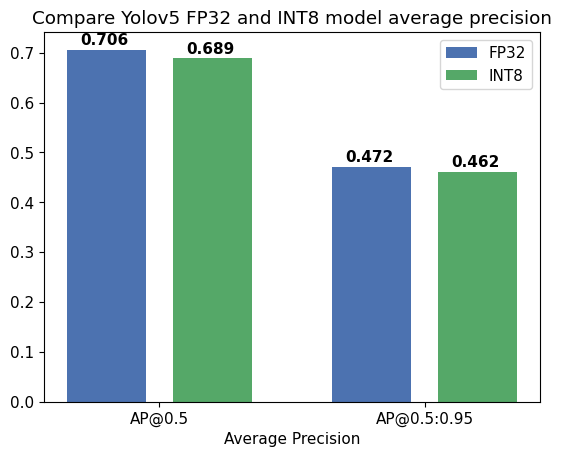

In [15]:
%matplotlib inline
plt.style.use("seaborn-deep")
fp32_acc = np.array(list(metric_results_fp32.values()))
int8_acc = np.array(list(metric_results_i8.values()))
x_data = ("AP@0.5", "AP@0.5:0.95")
x_axis = np.arange(len(x_data))
fig = plt.figure()
fig.patch.set_facecolor("#FFFFFF")
fig.patch.set_alpha(0.7)
ax = fig.add_subplot(111)
plt.bar(x_axis - 0.2, fp32_acc, 0.3, label="FP32")
for i in range(0, len(x_axis)):
    plt.text(
        i - 0.3,
        round(fp32_acc[i], 3) + 0.01,
        str(round(fp32_acc[i], 3)),
        fontweight="bold",
    )
plt.bar(x_axis + 0.2, int8_acc, 0.3, label="INT8")
for i in range(0, len(x_axis)):
    plt.text(
        i + 0.1,
        round(int8_acc[i], 3) + 0.01,
        str(round(int8_acc[i], 3)),
        fontweight="bold",
    )
plt.xticks(x_axis, x_data)
plt.xlabel("Average Precision")
plt.title("Compare Yolov5 FP32 and INT8 model average precision")

plt.legend()
plt.show()

## Inference Demo Performance Comparison

This part shows how to use the Ultralytics model detection code ["detect.py"](https://github.com/ultralytics/yolov5/blob/master/detect.py) to run synchronous inference, using the OpenVINO Python API on two images.

In [16]:
from export import attempt_load, yaml_save

model = attempt_load(
    f"{MODEL_PATH}/{MODEL_NAME}.pt", device="cpu", inplace=True, fuse=True
)  # load FP32 model
metadata = {"stride": int(max(model.stride)), "names": model.names}  # model metadata

int8_path = Path(config["model_int8"]["save_path"]) / config["model_int8"]["model_name"]
yaml_save(int8_path.with_suffix(".yaml"), metadata)  # add metadata.yaml

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


In [17]:
command_detect = f"python detect.py --weights " + config["model_int8"]["save_path"]
display(Markdown(f"`{command_detect}`"))
%sx $command_detect

`python detect.py --weights weights/yolov5s_openvino_model_INT8/`

["\x1b\x1bdetect: \x1bweights=['weights/yolov5s_openvino_model_INT8/'], source=data\\images, data=data\\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1",
 'YOLOv5  v7.0-128-gb96f35c Python-3.10.9 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)',
 '',
 'Loading weights\\yolov5s_openvino_model_INT8 for OpenVINO inference...',
 'image 1/2 D:\\code\\yolov5\\data\\images\\bus.jpg: 640x640 4 persons, 1 bus, 35.9ms',
 'image 2/2 D:\\code\\yolov5\\data\\images\\zidane.jpg: 640x640 2 persons, 1 tie, 27.9ms',
 'Speed: 436.8ms pre-process, 31.9ms inference, 2.5ms NMS per image at shape (1, 3, 640, 640)',
 'Results saved to \x1bruns\\detect\\exp\x1b'

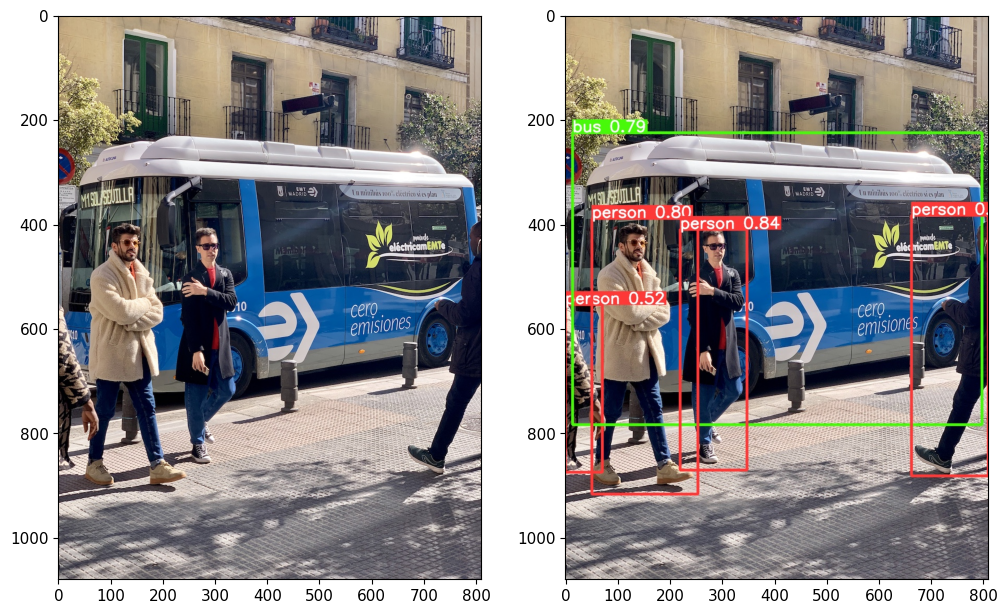

In [18]:
%matplotlib inline
import matplotlib.image as mpimg

fig2 = plt.figure(figsize=(12, 9))
fig2.patch.set_facecolor("#FFFFFF")
fig2.patch.set_alpha(0.7)
axarr1 = fig2.add_subplot(121)
axarr2 = fig2.add_subplot(122)
ori = mpimg.imread("./data/images/bus.jpg")
result = mpimg.imread("./runs/detect/exp/bus.jpg")
_ = axarr1.imshow(ori)
_ = axarr2.imshow(result)

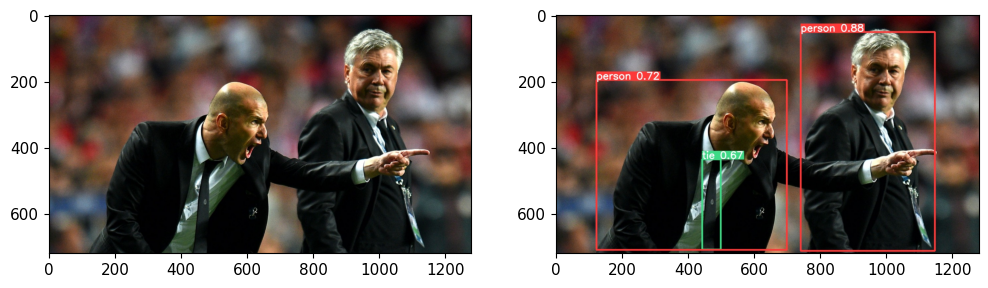

In [19]:
%matplotlib inline
import matplotlib.image as mpimg

fig2 = plt.figure(figsize=(12, 9))
fig2.patch.set_facecolor("#FFFFFF")
fig2.patch.set_alpha(0.7)
axarr1 = fig2.add_subplot(121)
axarr2 = fig2.add_subplot(122)
ori = mpimg.imread("./data/images/zidane.jpg")
result = mpimg.imread("./runs/detect/exp/zidane.jpg")
_ = axarr1.imshow(ori)
_ = axarr2.imshow(result)

## Benchmark

In [20]:
from openvino.runtime import Core
core = Core()

In [24]:
print("Inference FP32 model (OpenVINO IR) on CPU")
!benchmark_app -m  {fp32_path}.xml -d CPU -api async -t 15

if "GPU" in core.available_devices:
    print("Inference FP32 model (OpenVINO IR) on GPU")
    !benchmark_app -m  {fp32_path}.xml -d GPU -api async -t 15

Inference FP32 model (OpenVINO IR) on CPU
[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 36.93 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch 

In [27]:
print("Inference FP16 model (OpenVINO IR) on CPU")
!benchmark_app -m {fp16_path}.xml -d CPU -api async -t 15

if "GPU" in core.available_devices:
    print("Inference FP16 model (OpenVINO IR) on GPU")
    !benchmark_app -m {fp16_path}.xml -d GPU -api async -t 15

Inference FP16 model (OpenVINO IR) on CPU
[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 30.51 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch 

In [26]:
print("Inference INT8 model (OpenVINO IR) on CPU")
!benchmark_app -m {int8_path}.xml -d CPU -api async -t 15

if "GPU" in core.available_devices:
    print("Inference INT8 model (OpenVINO IR) on GPU")
    !benchmark_app -m {int8_path}.xml -d GPU -api async -t 15

Inference INT8 model (OpenVINO IR) on CPU
[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 38.90 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch 

## References

* [Ultralytics YOLOv5](https://github.com/ultralytics/yolov5)
* [OpenVINO Post-training Optimization Tool](https://docs.openvino.ai/latest/pot_introduction.html)
* [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo)
* [Accuracy Checker](https://github.com/openvinotoolkit/open_model_zoo/blob/master/tools/accuracy_checker/README.md)
